We will be building several classifcation models and comparing their performance in predicting cardiovascular disease. Within this notebook, we will start with Logistic Regression, then a non-linear Support Vector Classifier model. We will implement and test each model first without hyperparameter tuning, using default parameters. Afterwards, we will use GridSearchCV to optimize hyperparameters for improved accuracy, giving us a fairer comparison between models.


First, we're going to be establishing a train test split, as well as normalizing some of the variables using a StandardScaler object. But first, we'll import our data again and one-hot encode bp_category. For the purpose of scaling and eliminating the possibility of multicollinearity, we will drop the age_years column.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("cardio_data_clean.csv")

In [3]:
df = pd.get_dummies(df, drop_first=True)

%run model_utils.ipynb
df = bool_to_int(df)

df = df.drop('age_years', axis=1)

In [4]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp_category_Hypertension Stage 1,bp_category_Hypertension Stage 2,bp_category_Normal
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,1,0,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,0,1,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,1,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,0,1,0
4,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,1,0,0


# Data Preprocessing

Let's now import the appropriate libraries. Most of our columns have wide numeric ranges and would benefit from scaling. We will only be scaling continous variables, while leaving binary/dummy variables untouched to ensure all features are on a comparable scale for modeling. 

First, let's split the raw data into a train test split, fit the scaler/transformer on our training data, and then transform both the training and the test data.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [6]:
X = df.drop('cardio', axis=1)
y = df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

For the purpose of simplifying the process, we'll use a ColumnTransformer to selectively scale only the continuous numerical features that benefit from normalization. After transformation, we'll overwrite the original X_train and X_test variables with the scaled DataFrames that combine both the scaled columns and the nonscaled columns. 

In [7]:
scale_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi']

ct = ColumnTransformer(transformers=[('scale', StandardScaler(), scale_cols)], remainder='passthrough')

X_train_transform = ct.fit_transform(X_train)
X_test_transform = ct.transform(X_test)

In [8]:
scaled_cols = scale_cols
other_cols = [col for col in X.columns if col not in scale_cols]
all_cols = scaled_cols + other_cols

X_train = pd.DataFrame(X_train_transform, columns=all_cols, index=X_train.index)
X_test = pd.DataFrame(X_test_transform, columns=all_cols, index=X_test.index)

Now that we've scaled the appropriate columns and kept the original column names/indexes, let's move on to building and evaluating our classification models. 

# Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [40]:
log_model = LogisticRegression()

In [41]:
log_model.fit(X_train, y_train)

LogisticRegression()

In [42]:
log_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

These are the default parameters that the model used. Let's take a look at the coefficients of the model. These coefficients represent the strength and direction of the relationship between each feature and the likelihood of the model predicting that cardio = 1. A positive coefficent represents that as the feature increases, this likelihood of predicting cardio equaling 1, while a negative coefficient suggests the opposite. 

It's important to note that different models calculate these feature importances in different ways:
- Logistic Regression provides coefficients which indicate the direction and also magnitude.
- Tree-based models calculate feature importances based on how much each feature reduces impurity in the decision trees.
- Other models, such as SVC, use permutation importance to estimate how much each feature contributes to model performance by measuring the impact of randomly shuffling that feature around a set number of times.



We'll be saving each model's feature importances, both before and after tuning, going forth. For Logistic Regression, we'll be saving the regression coefficients, and for our Support Vector Classifier model, we'll be saving the permutation importance.

Let's first visualize these coefficients across each of the features to understand which variables the model considers most important.

In [43]:
log_model.coef_

array([[ 0.36921413,  0.02952229,  0.04353808,  0.8877844 ,  0.09160594,
         0.09612236, -0.01954287,  0.48891963, -0.11528823, -0.15963049,
        -0.21514656, -0.24991464,  0.09168347,  0.34371536,  0.38692268]])

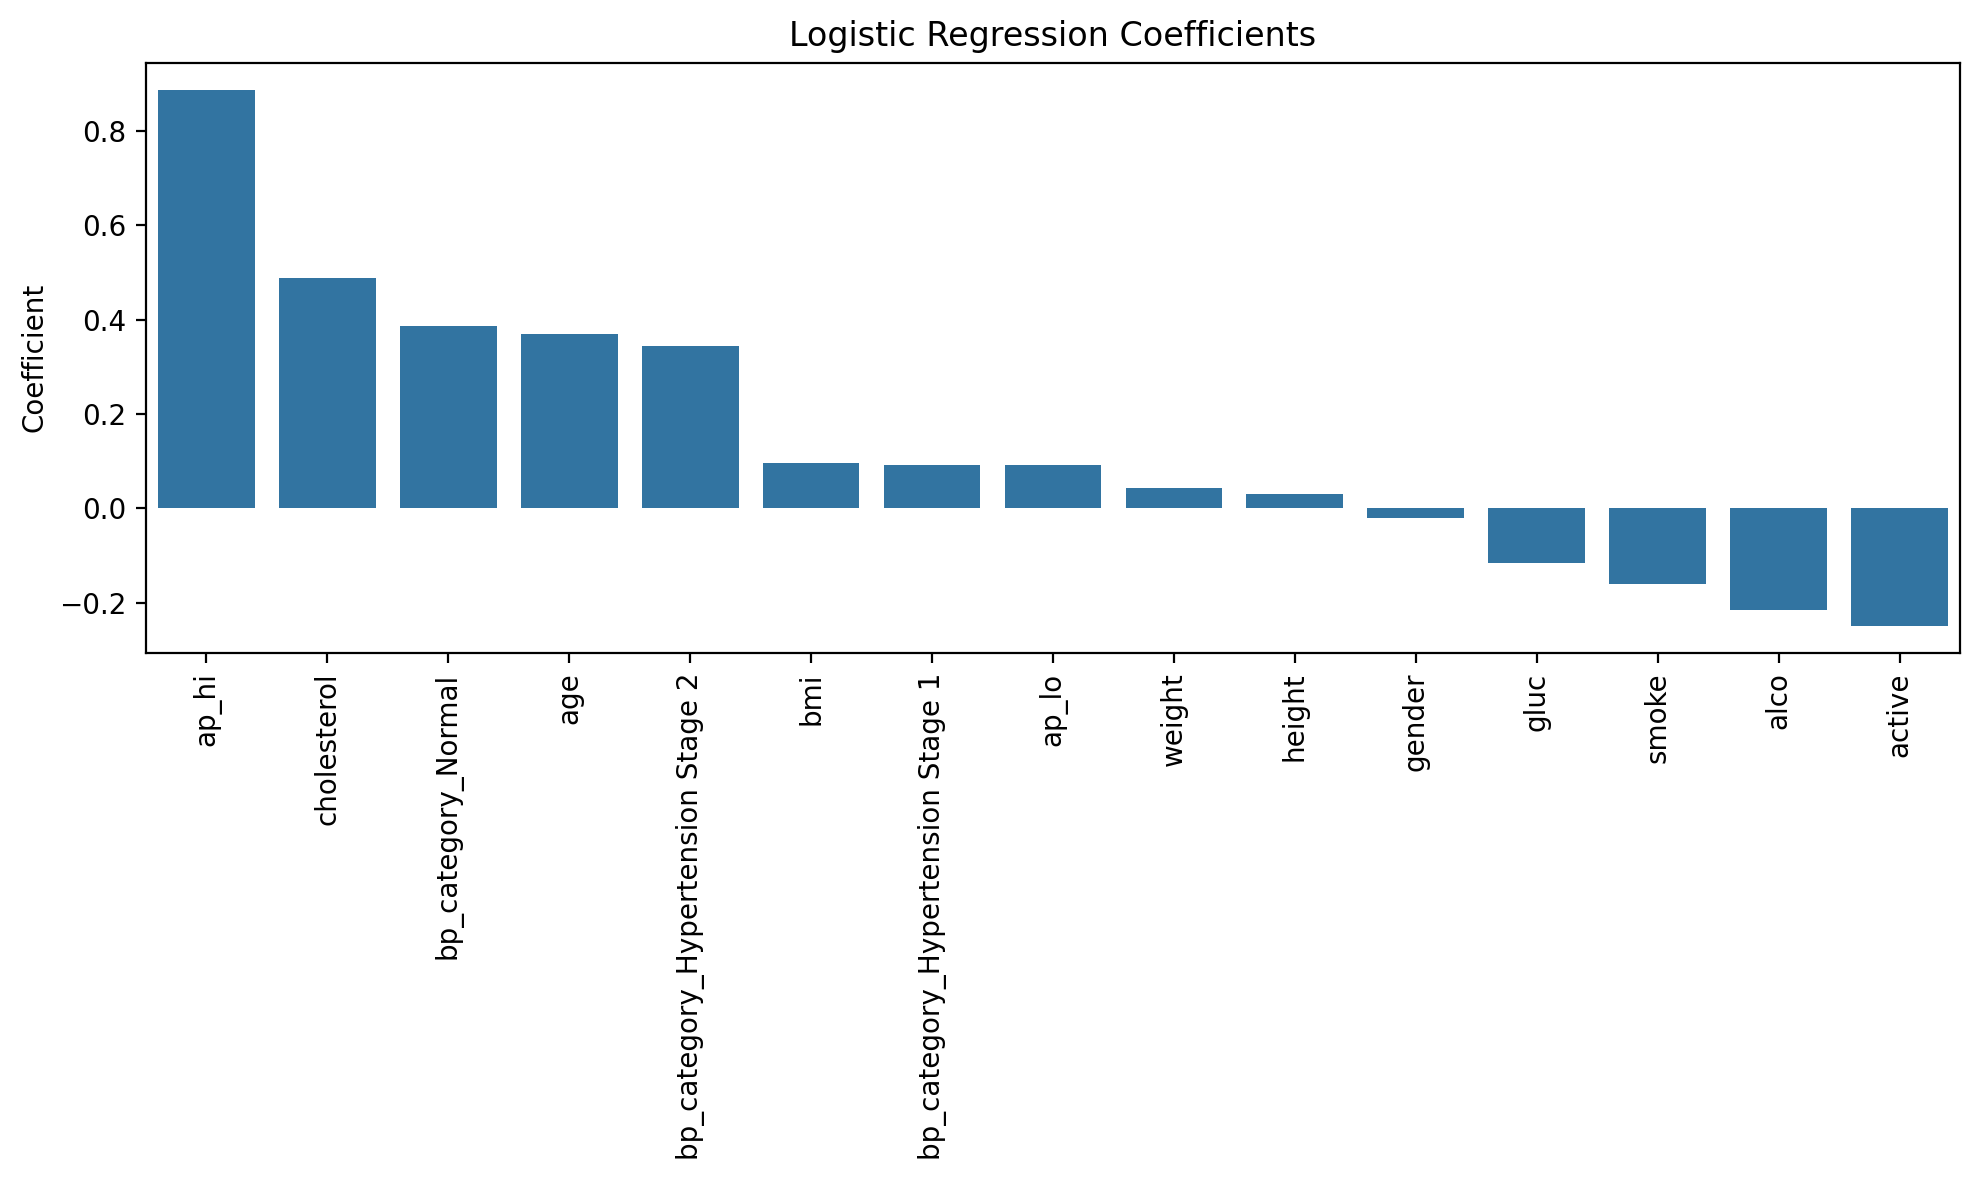

In [44]:
plot_logreg_coefficients(log_model, X_train.columns)

We can see that ap_hi, cholesterol, bp_category, and age received the highest positive coefficients, suggesting they were the strongest predictors of cardiovascular disease. Features like active, alco, and smoke were weighed negatively, meaning the presence of higher values in these variables were associated with a lower predicted risk.

Using the pickle module in Python and functions from the model_utils notebook, we will be storing each model's feature importances, both before and after hyperparameter tuning. 

In [45]:
export_logreg_coefficients(log_model, X_train.columns, "logistic_regression")

Next, we'll evaluate the model's performance. Similar to feature importances, we will be storing each model's results, both before and after hyperparameter tuning, using the pickle module. After evaluating each model we will save its results into a reusable variable, model_results, so we can easily access and aggregate metrics 
later when comparing performance across models.

Each model will have its own .pkl file which we can later import for analysis and visualization. 

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [47]:
log_pred = log_model.predict(X_test)

In [48]:
accuracy_score(y_test, log_pred)

0.7222403391488668

In [49]:
confusion_matrix(y_test, log_pred)

array([[5001, 1253],
       [2154, 3858]], dtype=int64)

In [50]:
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75      6254
           1       0.75      0.64      0.69      6012

    accuracy                           0.72     12266
   macro avg       0.73      0.72      0.72     12266
weighted avg       0.73      0.72      0.72     12266



In [51]:
export_model_results(y_test, log_pred, 'Logistic Regression (Untuned)', 'model_results/logistic_regression.pkl')

The base model achieved around 72.2% accuracy. Notably, its recall for the positive class (cardio = 1) was around 64%, meaning about one-third of actual disease cases go undetected by the model. 

Now that we've evaluated the model's baseline performance, we'll see if we can get any improvements by tuning its hyperparameters. We will define a parameter grid and provide a list of possible values for each parameter.

In [52]:
log_param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['liblinear'], 'max_iter': [1000]}

In [53]:
log_model = LogisticRegression()

grid_log = GridSearchCV(log_model, param_grid=log_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [54]:
grid_log.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [1000],
                         'penalty': ['l2'], 'solver': ['liblinear']},
             scoring='accuracy')

In [55]:
log_grid_pred = grid_log.predict(X_test)

In [57]:
accuracy_score(y_test, log_grid_pred)

0.7224849176585684

In [58]:
confusion_matrix(y_test, log_grid_pred)

array([[5005, 1249],
       [2155, 3857]], dtype=int64)

In [59]:
print(classification_report(y_test, log_grid_pred))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75      6254
           1       0.76      0.64      0.69      6012

    accuracy                           0.72     12266
   macro avg       0.73      0.72      0.72     12266
weighted avg       0.73      0.72      0.72     12266



In [60]:
export_model_results(y_test, log_grid_pred, 'Logistic Regression (Tuned)', 'model_results/logistic_regression_tuned.pkl')

After hyperparameter tuning using GridSearchCV, we found that there was extremely minimal improvements compared to the default model. This suggests that the model is relatively stable and isn't very sensitive to changes in regularization strength. 

Let's visualize and save the regression coefficients.

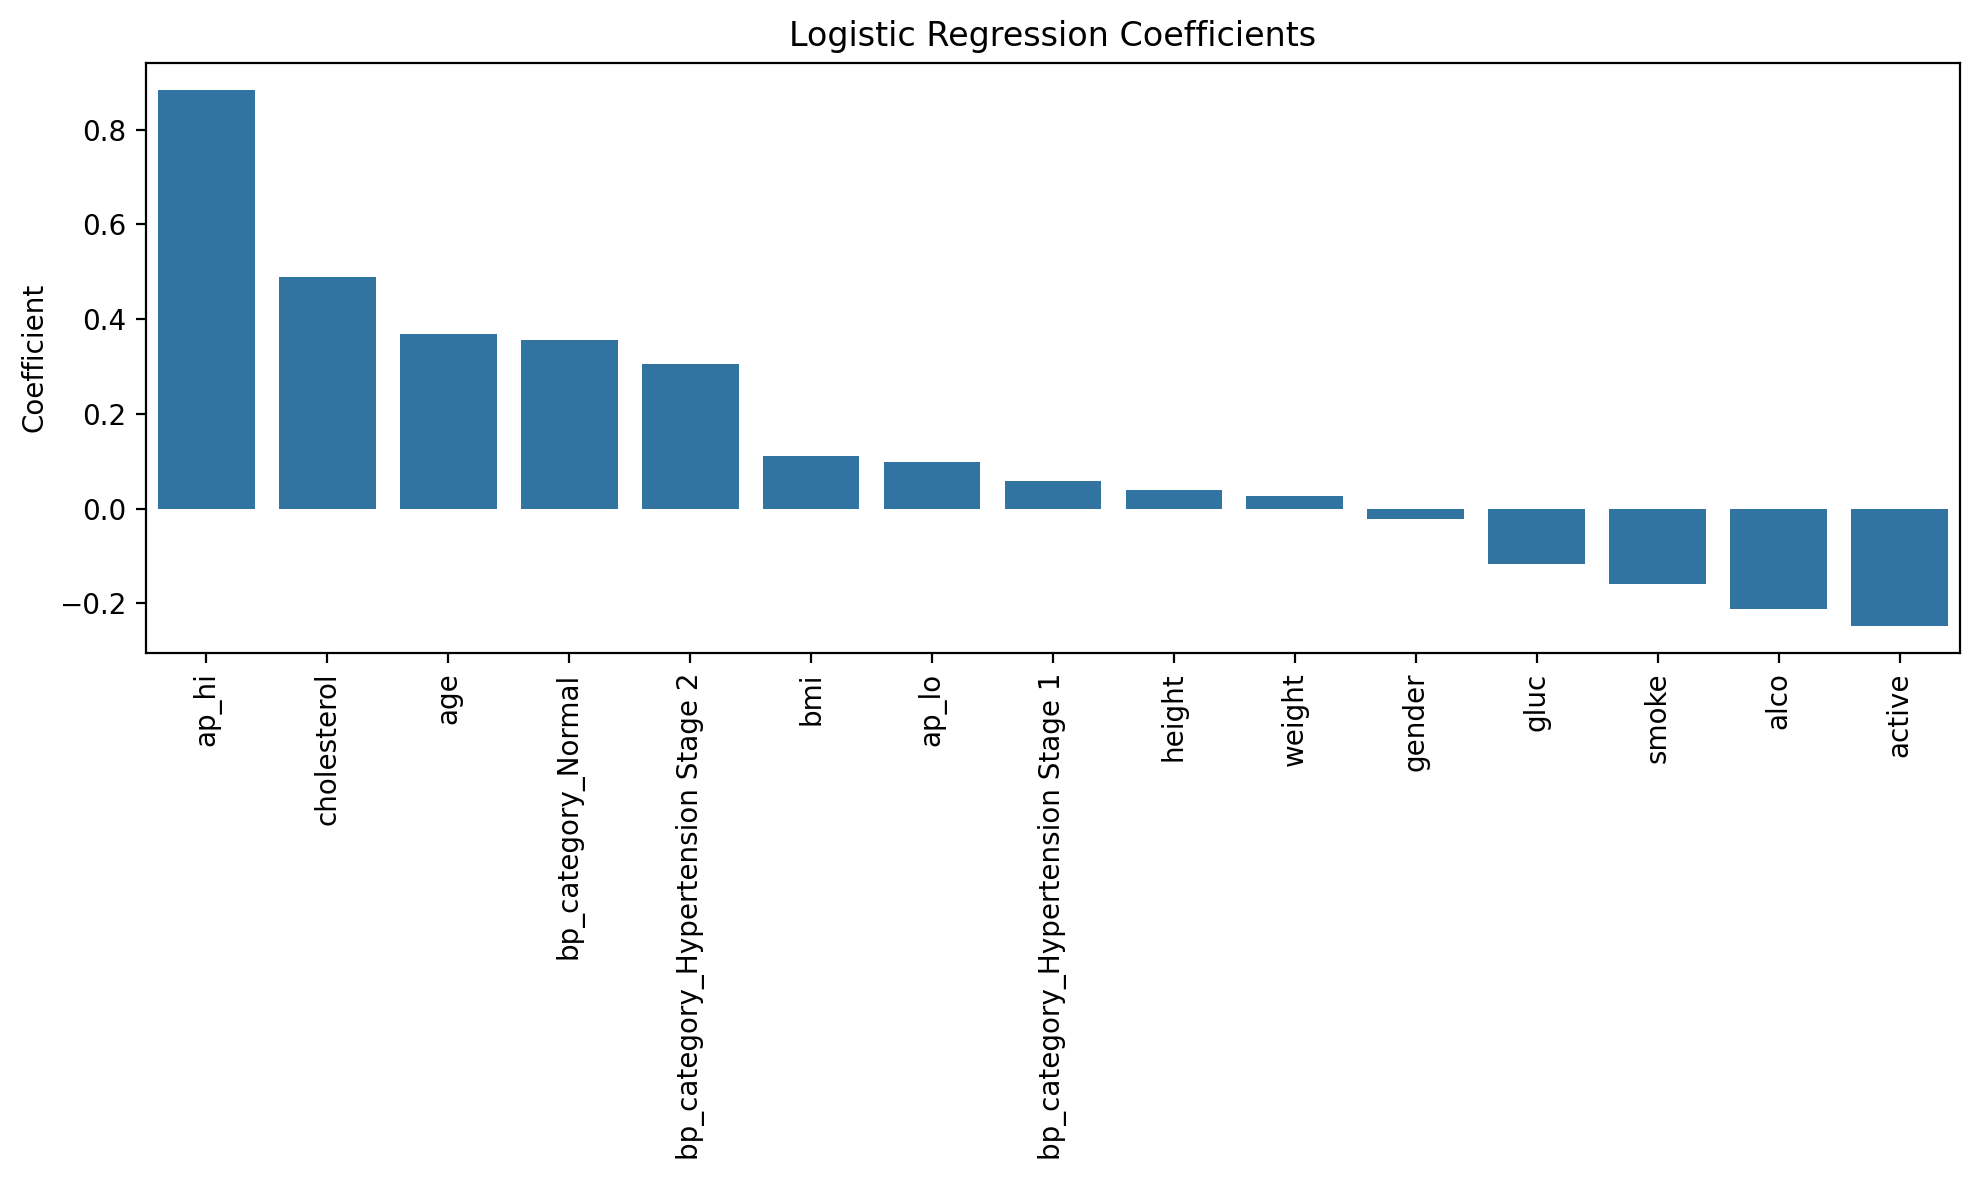

In [61]:
plot_logreg_coefficients(grid_log.best_estimator_, X_train.columns)

It seems that the regression coefficients are nearly unchanged after hyperparameter tuning. Before we move on, let's make sure we save the coefficients for future analysis.

In [62]:
export_logreg_coefficients(grid_log.best_estimator_, X_train.columns, "logistic_regression_tuned")

Now, we'll build and evaluate the performance of a Support Vector Classifier (SVC) model.

# Support Vector Classifier

In [63]:
from sklearn.svm import SVC

In [64]:
svc_model = SVC()

In [65]:
svc_model.fit(X_train, y_train)

SVC()

In [66]:
svc_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

The default kernel parameter for SVC is 'rbf', which is a non-linear kernel, which means we won't be able to access and visualize the model's coefficients. Instead, we'll be using permutation importance to get an estimate of how much each individual feature contributes to how well a model performs. Due to high computation time, we'll be using a sample of the test data.

We'll go ahead and evaluate the model's performance with these default parameters first.

In [67]:
svc_pred = svc_model.predict(X_test)

In [68]:
accuracy_score(y_test, svc_pred)

0.7287624327409098

In [69]:
confusion_matrix(y_test, svc_pred)

array([[4998, 1256],
       [2071, 3941]], dtype=int64)

In [70]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6254
           1       0.76      0.66      0.70      6012

    accuracy                           0.73     12266
   macro avg       0.73      0.73      0.73     12266
weighted avg       0.73      0.73      0.73     12266



In [71]:
export_model_results(y_test, svc_pred, 'Support Vector Classifier (Untuned)', 'model_results/svc.pkl')

Let's use permutation importance to get an understanding of features have the most impact on the model's predictive performance.

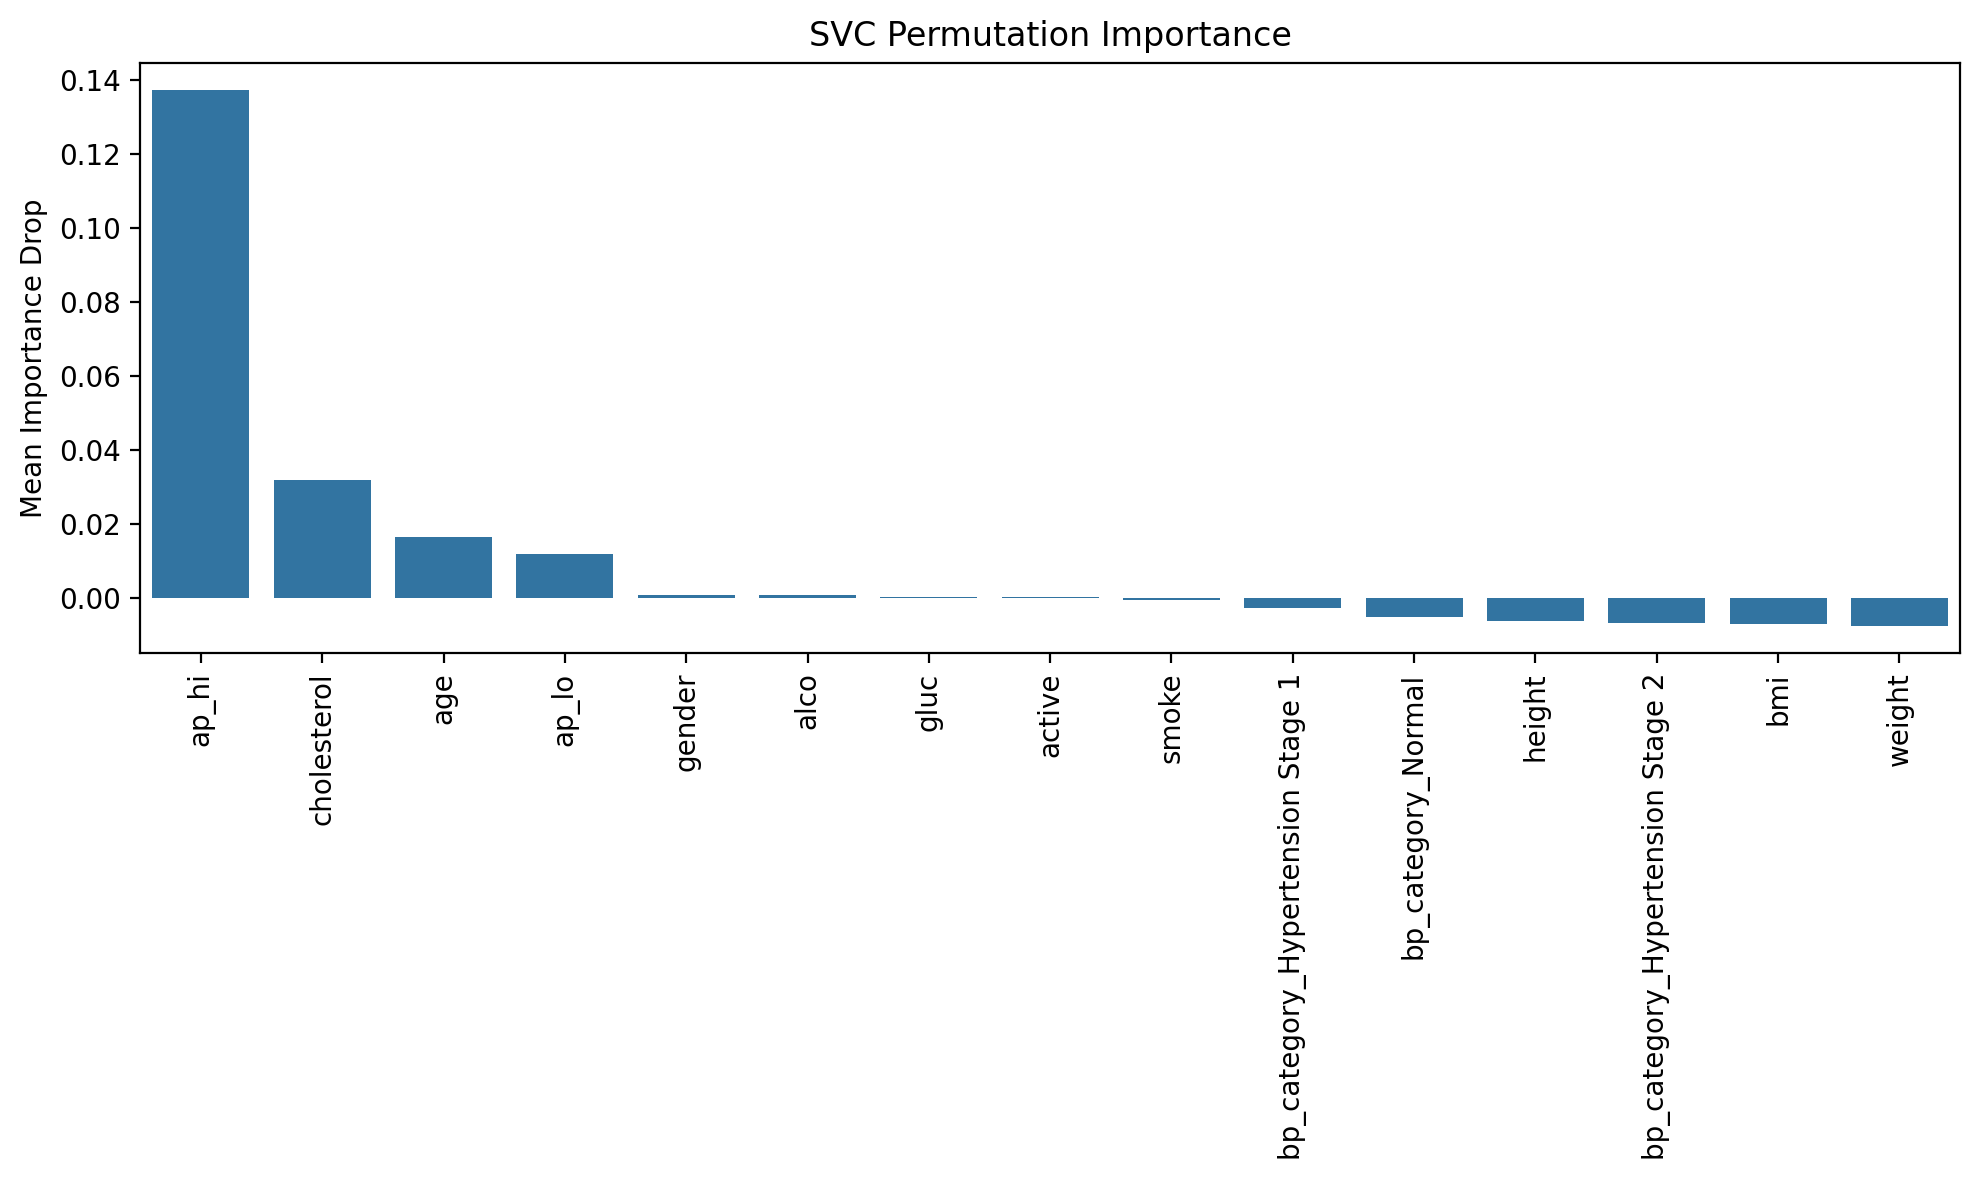

In [72]:
plot_permutation_importance(svc_model, X_test, y_test, X_train.columns, title="SVC Permutation Importance")

We see that ap_hi had the highest importance by far. Shuffling this feature caused a significant drop in accuracy (~0.14) meaning the model relied on it heavily for predicting cardiovascular disease. Some features even showed slight negative importance, like height, which might be due to random variation.

Let's save the permutation importances of the model before hyperparameter tuning.

In [73]:
export_permutation_importance(svc_model, X_test, y_test, X_train.columns, "svc")

Now that we've evaluated the baseline performance of the Support Vector Classifier model, visualized and saved the permutation importances, we'll proceed with hyperparameter tuning using GridSearchCV and create a parameter grid with a range of values for the regularization parameter C, and kernal coefficient gamma, among others.

In [74]:
svc_param_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

In [75]:
svc_model = SVC()

In [76]:
grid_svc = GridSearchCV(svc_model, param_grid=svc_param_grid, cv=5, scoring='accuracy', n_jobs=-2)

In [77]:
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-2,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 10],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [80]:
grid_svc.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

After using GridSearchCV, these are the best performing parameters for our model. We'll proceed with testing its performance.

In [81]:
svc_grid_pred = grid_svc.predict(X_test)

In [82]:
accuracy_score(y_test, svc_grid_pred)

0.7291700635904125

In [83]:
confusion_matrix(y_test, svc_grid_pred)

array([[5010, 1244],
       [2078, 3934]], dtype=int64)

In [84]:
print(classification_report(y_test, svc_grid_pred))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6254
           1       0.76      0.65      0.70      6012

    accuracy                           0.73     12266
   macro avg       0.73      0.73      0.73     12266
weighted avg       0.73      0.73      0.73     12266



In [85]:
export_model_results(y_test, svc_grid_pred, 'Support Vector Classifier (Tuned)', 'model_results/svc_tuned.pkl')

The Support Vector Machine (SVM) model achieved an accuracy of ~72.9% on the test, close to that of the Logistic Regression model. This indicates that the relationships in the data may be largely linear, so the more complex and non-linear SVM didn't yield such a big gain. 

Additionally, similarly to our Logistic Regression model, the SVM model had minimal improvements after tuning its hyperparameters. Even after tuning the SVM's regularization (C) and kernel parameters, the accuracy only rose by about ~0.0003%, which is a negligible difference. Further gains may require additional features or a different model entirely.

Like before, we'll visualize permutation importance to see how much each feature contributes to the model's predictions.

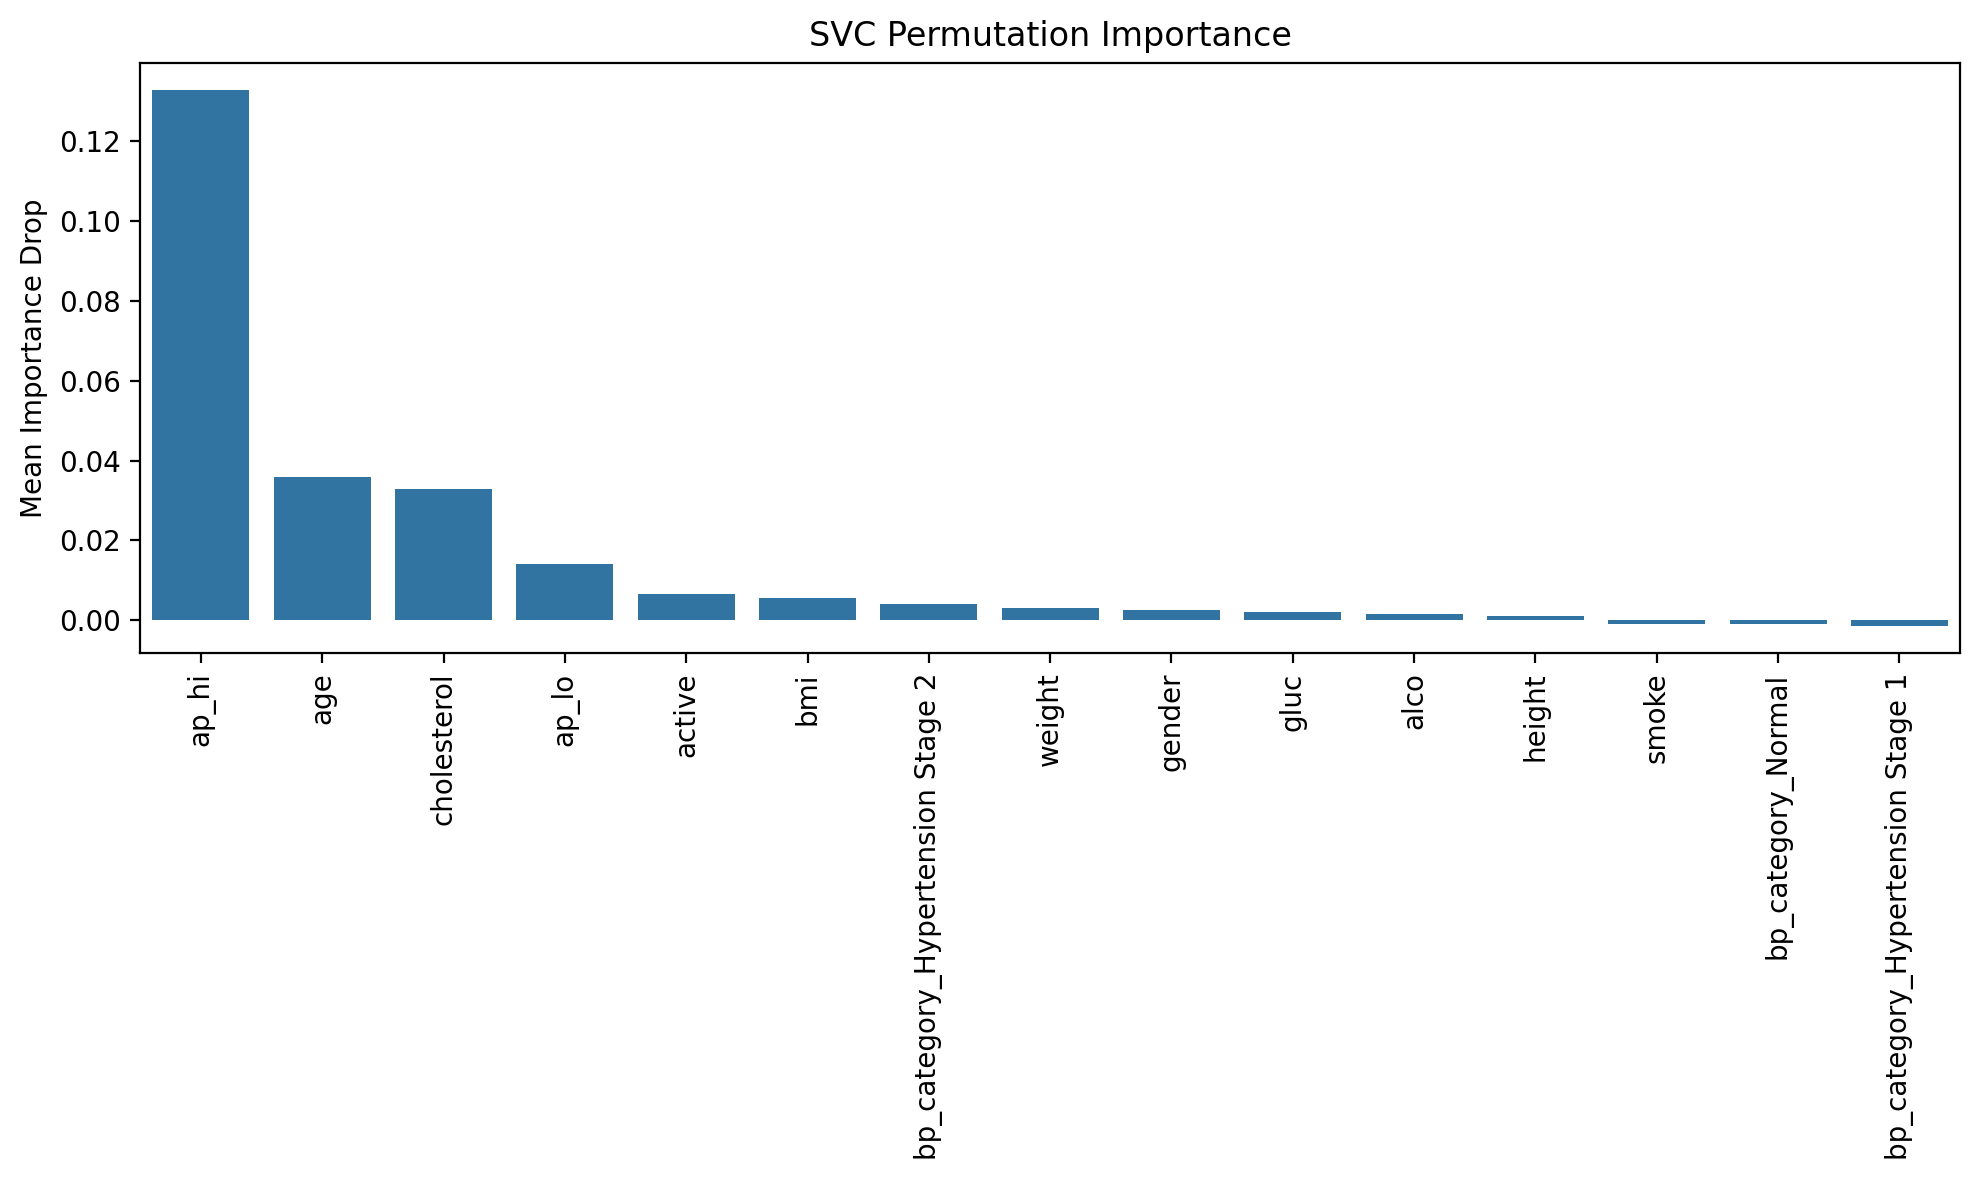

In [119]:
plot_permutation_importance(grid_svc.best_estimator_, X_test, y_test, X_train.columns, title="SVC Permutation Importance")

ap_hi remains by far the most important feature, with a very large performance drop when permuted. This means that the tuned SVC model also heavily relies on systolic blood pressure. Age and cholesterol follow afterwards, showing moderate drops. It appears that age gained importance compared to the untuned model, meaning tuning might have allowed the model to better leverage the use of age. The trend of assigning little value to behavioral and categorical variables continues.

In [120]:
export_permutation_importance(grid_svc.best_estimator_, X_test, y_test, X_train.columns, "svc_tuned")

 We'll transition into a new notebook, cardiovascular_disease_tree_modelling, to explore and evaluate tree-based models, such as Random Forests and Boosted Trees models. 